In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [12]:
train_path="Dataset/Train"
test_path="Dataset/Test"
val_path="Dataset/Validation"

In [13]:
train_datagen = ImageDataGenerator( 
                                   rescale=1./255,
                                   #rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                  ) 
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(  rescale=1./255.0)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299,299),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299,299),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (299,299),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [14]:
input_shape = (299, 299, 3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

combined_model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                             

In [16]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01  # You can set your desired learning rate value

# Create an Adam optimizer instance with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

In [17]:
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
history = combined_model.fit(
    training_set,
    epochs=10,
    validation_data=val_set,
    #callbacks=[callbacks]
)

Epoch 1/10


2024-04-27 18:24:33.097362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600
2024-04-27 18:24:33.347082: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 775.69MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-04-27 18:24:33.347127: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 775.69MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-04-27 18:24:33.347137: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more me

4376/4376 [==============================] - 561s 127ms/step - loss: 0.2654 - accuracy: 0.8872 - val_loss: 0.2574 - val_accuracy: 0.8972
Epoch 2/10
4376/4376 [==============================] - 551s 126ms/step - loss: 0.1825 - accuracy: 0.9264 - val_loss: 0.2986 - val_accuracy: 0.8876
Epoch 3/10
4376/4376 [==============================] - 551s 126ms/step - loss: 0.1436 - accuracy: 0.9426 - val_loss: 0.2215 - val_accuracy: 0.9172
Epoch 4/10
4376/4376 [==============================] - 552s 126ms/step - loss: 0.1099 - accuracy: 0.9559 - val_loss: 0.2494 - val_accuracy: 0.9104
Epoch 5/10
4376/4376 [==============================] - 548s 125ms/step - loss: 0.0851 - accuracy: 0.9670 - val_loss: 0.2313 - val_accuracy: 0.9192
Epoch 6/10
4376/4376 [==============================] - 553s 126ms/step - loss: 0.0675 - accuracy: 0.9737 - val_loss: 0.2753 - val_accuracy: 0.9138
Epoch 7/10
4376/4376 [==============================] - 551s 126ms/step - loss: 0.0550 - accuracy: 0.9787 - val_loss: 0.289

In [19]:
combined_model.save("InceptionV3.h5")

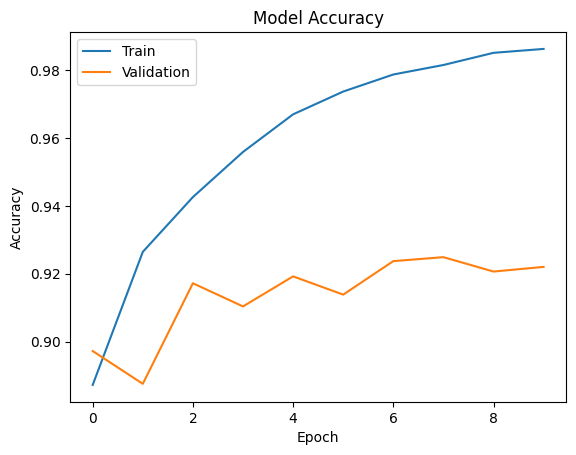

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

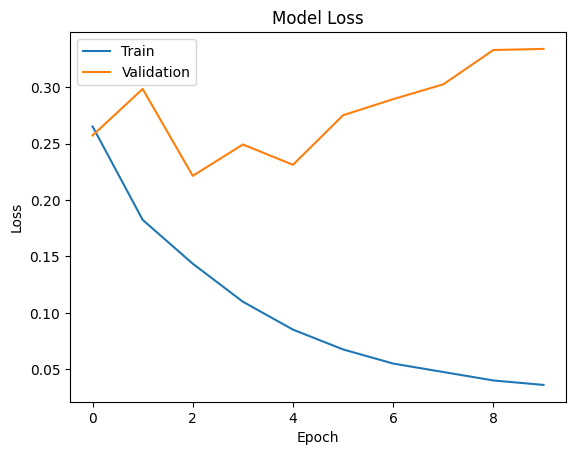

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
# Predict the classes using the test set
test_pred = combined_model.predict(test_set)
test_pred_classes = np.round(test_pred)

# Get the true classes of the test set
test_true_classes = test_set.classes

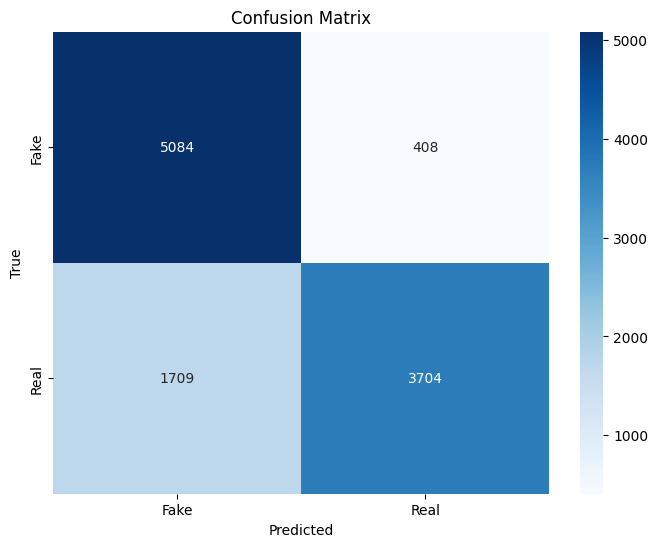

In [24]:
# Plot confusion matrix as a heatmap
# Generate confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
evaluation = combined_model.evaluate(test_set)

341/341 [==============================] - 33s 97ms/step - loss: 1.3863 - accuracy: 0.8059


In [26]:
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

Test Accuracy: 80.59%


In [27]:
#Classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=["Class 0", "Class 1"], labels=[0, 1], digits=4)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0     0.7484    0.9257    0.8277      5492
     Class 1     0.9008    0.6843    0.7777      5413

    accuracy                         0.8059     10905
   macro avg     0.8246    0.8050    0.8027     10905
weighted avg     0.8240    0.8059    0.8029     10905



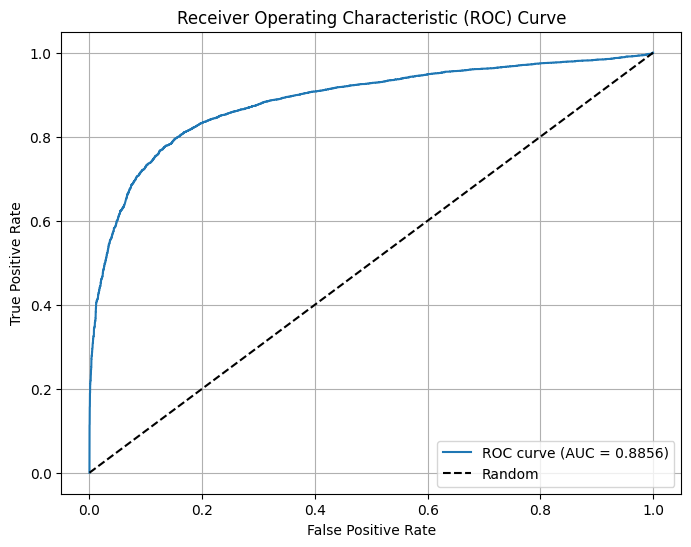

In [28]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true_classes, test_pred)

# Calculate AUC
auc = roc_auc_score(test_true_classes, test_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

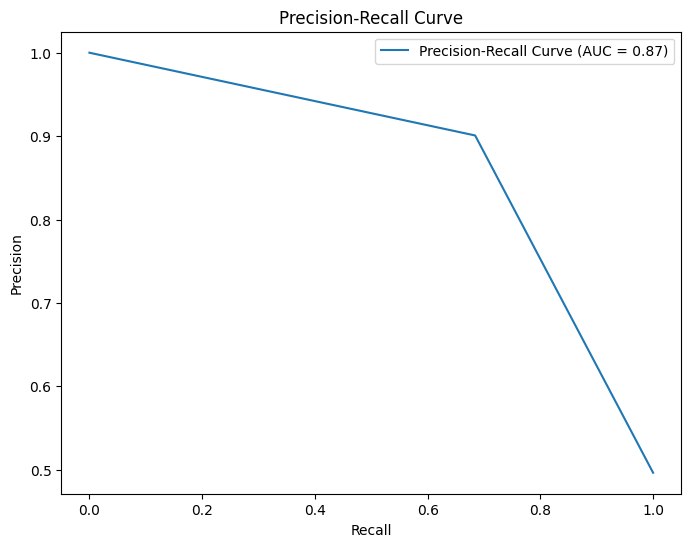

In [29]:
from sklearn.metrics import precision_recall_curve, auc
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(test_true_classes, test_pred_classes)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [30]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(test_true_classes, test_pred_classes).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')

Sensitivity (True Positive Rate): 0.6843
Specificity (True Negative Rate): 0.9257


In [31]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Assuming you have obtained test_pred_classes and test_true_classes as described earlier

# Calculate F1 score for the test classes
f1 = f1_score(test_true_classes, test_pred_classes)
# Calculate accuracy to get error rate
accuracy = accuracy_score(test_true_classes, test_pred_classes)
error_rate = 1 - accuracy
# Calculate G-mean
g_mean = (sensitivity * specificity) ** 0.5

# Calculate F-measure
f_measure = 2 * ((sensitivity * specificity) / (sensitivity + specificity))

print(f'F1 Score: {f1:.4f}')
print(f'Error Rate: {error_rate:.4f}')
print(f'G-mean: {g_mean:.4f}')
print(f'F-measure: {f_measure:.4f}')

F1 Score: 0.7777
Error Rate: 0.1941
G-mean: 0.7959
F-measure: 0.7869
